In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import h5py
from IPython.display import display
import numpy as np
from os.path import join as pj
from os import getcwd as cwd
import pandas as pd
import random
import sys
import torch
from tqdm import tqdm
import visdom

# Data Augument
from dataset.classification.loader import create_validation_split, load_validation_data, create_train_data, create_train_data_DCL
# Evaluation
from evaluation.classification.evaluate import accuracy, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

### Test Config

In [3]:
class args:
    # experiment_name
    experiment_name = "resnet50_b20_r45_lr1e-5_crossvalid_correction_LowTrainable"
    # data split
    train_ratio = 0.8 # unused parameters
    test_ratio = 0.2
    # paths
    all_data_path = pj(cwd(), "data/all_classification_data/classify_insect_std_aquatic")
    model_root = pj(cwd(), "output_model/classification/ResNet101", experiment_name)
    figure_root = pj(cwd(), "figure/classification/ResNet101", experiment_name)
    # class names to visualize
    #labels =  ['Aquatic_insects', 'Other_insects']
    labels =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
               'Lepidoptera', 'Plecoptera', 'Trichoptera']
    #labels =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
    #           'Lepidoptera', 'Plecoptera', 'Trichoptera', 
    #           'Coleoptera', 'Hemiptera', 'medium insect', 'small insect']
    # train config
    model_name = "ResNet50" # choice ["ResNet18", "ResNet34", "ResNet50", "ResNet101"]
    use_DCL = False
    division_number = 7
    neighborhood_range = 1
    cls_weight = 1
    dest_weight = 10
    coord_weight = 0.1
    bs = 20
    lr = 1e-5
    nepoch = 40
    rotate = 45
    pretrain = True
    freeze = False
    sampling = None # choice [None, "RandomSample", "RandomOverSample"]
    augment = None # choice [None, "RandomSizeCrop"]
    optimizer = "AdamW" # choice ["Adam, AdamW"]
    correction_term = True
    # test config
    save_fig = True
    save_df = True
    # visdom
    visdom = True
    port = 8097

### Load Model

In [4]:
# Model
if args.model_name=="ResNet18":
    from model.resnet.resnet18 import ResNet18
elif args.model_name=="ResNet34":
    from model.resnet.resnet34 import ResNet34
elif args.model_name=="ResNet50":
    from model.resnet.resnet50 import ResNet50
elif args.model_name=="ResNet101":
    from model.resnet.resnet101 import ResNet101
else:
    print("error! write correct model name!")

In [5]:
if args.model_name=="ResNet18":
    model = ResNet18(len(args.labels), use_DCL=args.use_DCL, division_number=args.division_number, pretrain=args.pretrain, training=False).cuda()
elif args.model_name=="ResNet34":
    model = ResNet34(len(args.labels), use_DCL=args.use_DCL, division_number=args.division_number, pretrain=args.pretrain, training=False).cuda()
elif args.model_name=="ResNet50":
    model = ResNet50(len(args.labels), use_DCL=args.use_DCL, division_number=args.division_number, pretrain=args.pretrain, training=False, vis_feature=True).cuda()
elif args.model_name=="ResNet101":
    model = ResNet101(len(args.labels), use_DCL=args.use_DCL, division_number=args.division_number, pretrain=args.pretrain, training=False).cuda()
else:
    print("error! write correct model name!")

In [6]:
model.load_state_dict(torch.load(pj(args.model_root, "final.pth")))

### Make test data

In [7]:
with h5py.File(args.all_data_path) as f:
    X = f["X"][:]
    Y = f["Y"][:]
_, ntests = np.unique(Y, return_counts=True)
train_idxs, test_idxs = create_validation_split(Y, args.test_ratio)

In [8]:
if args.sampling == "RandomSample":
    print("sampling = RandomSample")
    new_train_idx = get_randomsampled_idx(Y, train_idxs[4])
    xtr, ytr, xte, yte = load_validation_data(X, Y, new_train_idx, test_idxs[4])
elif args.sampling == "RandomOverSample":
    print("sampling == RandomOverSample")
    new_train_idx = get_randomoversampled_idx(Y, train_idxs[4])
    xtr, ytr, xte, yte = load_validation_data(X, Y, new_train_idx, test_idxs[4])
else:
    print("sampling = None")
    xtr, ytr, xte, yte = load_validation_data(X, Y, train_idxs[4], test_idxs[4])

sampling = None


# Visualize Model Feature

In [9]:
index = 0

In [46]:
index += 1

In [47]:
x = xte[index][None, :, :, :].cuda()
model_features = model(x)
model_features.keys()

dict_keys(['conv_block_1', 'conv_block_2', 'conv_block_3', 'conv_block_4'])

### Input Image

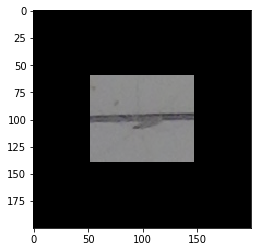

In [48]:
plt.imshow(xte[index].cpu().numpy().transpose(1,2,0).astype("uint8"))

### Conv Block 1

In [49]:
block1_index = 0

ブロック1の特徴量


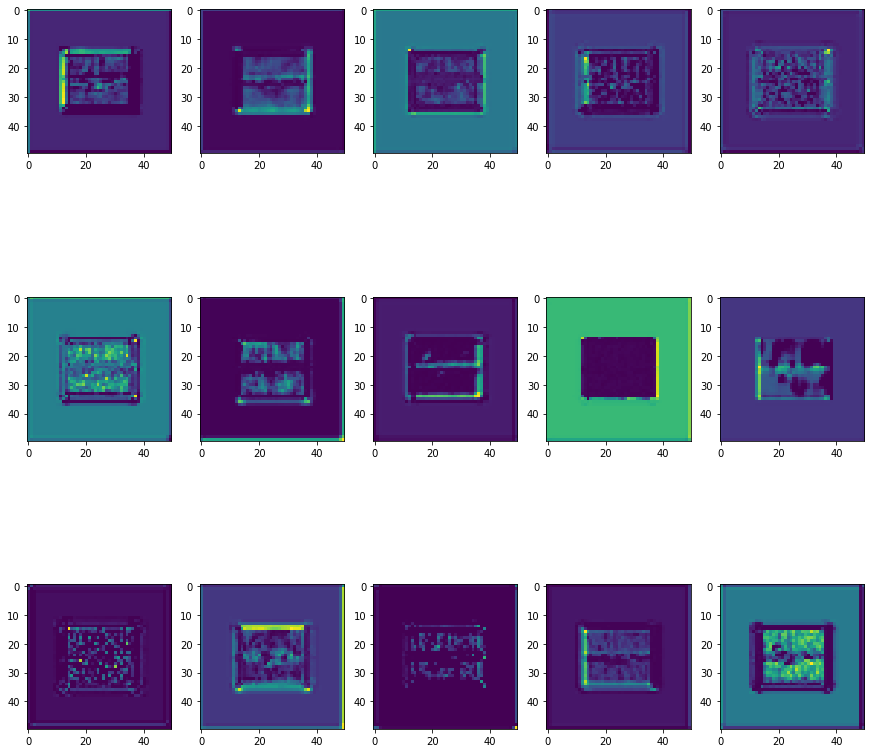

In [52]:
print("ブロック1の特徴量")
fig, axes = plt.subplots(3, 5, figsize=(15,15))
axes[0,0].imshow(model_features['conv_block_1'][0, block1_index].detach().cpu().numpy())
axes[0,1].imshow(model_features['conv_block_1'][0, block1_index + 1].detach().cpu().numpy())
axes[0,2].imshow(model_features['conv_block_1'][0, block1_index + 2].detach().cpu().numpy())
axes[0,3].imshow(model_features['conv_block_1'][0, block1_index + 3].detach().cpu().numpy())
axes[0,4].imshow(model_features['conv_block_1'][0, block1_index + 4].detach().cpu().numpy())
axes[1,0].imshow(model_features['conv_block_1'][0, block1_index + 5].detach().cpu().numpy())
axes[1,1].imshow(model_features['conv_block_1'][0, block1_index + 6].detach().cpu().numpy())
axes[1,2].imshow(model_features['conv_block_1'][0, block1_index + 7].detach().cpu().numpy())
axes[1,3].imshow(model_features['conv_block_1'][0, block1_index + 8].detach().cpu().numpy())
axes[1,4].imshow(model_features['conv_block_1'][0, block1_index + 9].detach().cpu().numpy())
axes[2,0].imshow(model_features['conv_block_1'][0, block1_index + 10].detach().cpu().numpy())
axes[2,1].imshow(model_features['conv_block_1'][0, block1_index + 11].detach().cpu().numpy())
axes[2,2].imshow(model_features['conv_block_1'][0, block1_index + 12].detach().cpu().numpy())
axes[2,3].imshow(model_features['conv_block_1'][0, block1_index + 13].detach().cpu().numpy())
axes[2,4].imshow(model_features['conv_block_1'][0, block1_index + 14].detach().cpu().numpy())
block1_index += 15

### Conv Block 2

In [53]:
block2_index = 0

ブロック2の特徴量


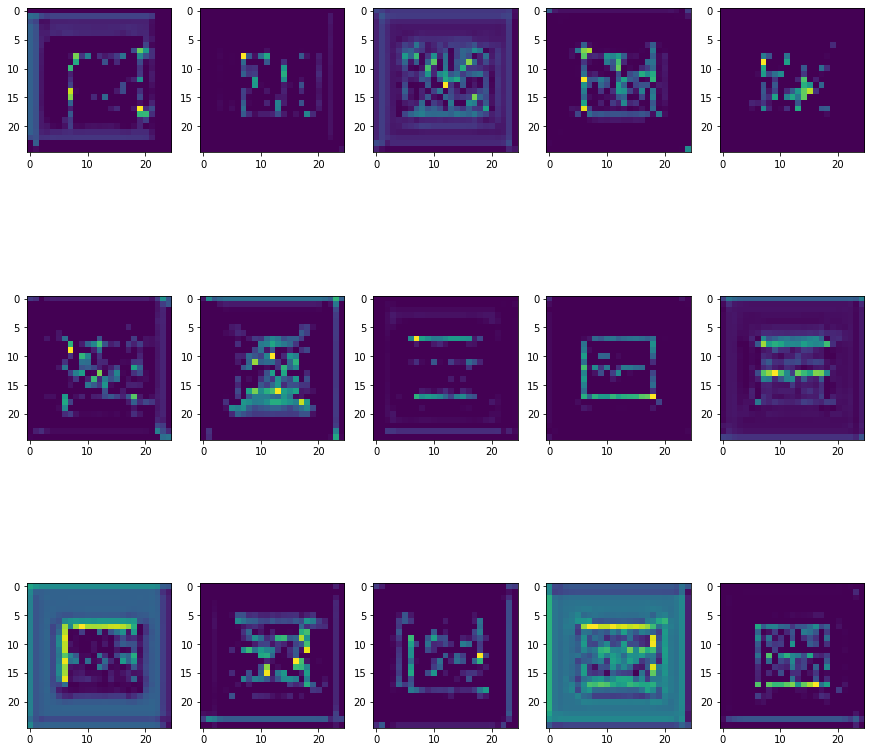

In [57]:
print("ブロック2の特徴量")
fig, axes = plt.subplots(3, 5, figsize=(15,15))
axes[0,0].imshow(model_features['conv_block_2'][0, block2_index].detach().cpu().numpy())
axes[0,1].imshow(model_features['conv_block_2'][0, block2_index + 1].detach().cpu().numpy())
axes[0,2].imshow(model_features['conv_block_2'][0, block2_index + 2].detach().cpu().numpy())
axes[0,3].imshow(model_features['conv_block_2'][0, block2_index + 3].detach().cpu().numpy())
axes[0,4].imshow(model_features['conv_block_2'][0, block2_index + 4].detach().cpu().numpy())
axes[1,0].imshow(model_features['conv_block_2'][0, block2_index + 5].detach().cpu().numpy())
axes[1,1].imshow(model_features['conv_block_2'][0, block2_index + 6].detach().cpu().numpy())
axes[1,2].imshow(model_features['conv_block_2'][0, block2_index + 7].detach().cpu().numpy())
axes[1,3].imshow(model_features['conv_block_2'][0, block2_index + 8].detach().cpu().numpy())
axes[1,4].imshow(model_features['conv_block_2'][0, block2_index + 9].detach().cpu().numpy())
axes[2,0].imshow(model_features['conv_block_2'][0, block2_index + 10].detach().cpu().numpy())
axes[2,1].imshow(model_features['conv_block_2'][0, block2_index + 11].detach().cpu().numpy())
axes[2,2].imshow(model_features['conv_block_2'][0, block2_index + 12].detach().cpu().numpy())
axes[2,3].imshow(model_features['conv_block_2'][0, block2_index + 13].detach().cpu().numpy())
axes[2,4].imshow(model_features['conv_block_2'][0, block2_index + 14].detach().cpu().numpy())
block2_index += 1

### Conv Block 3

In [58]:
block3_index = 0

ブロック3の特徴量


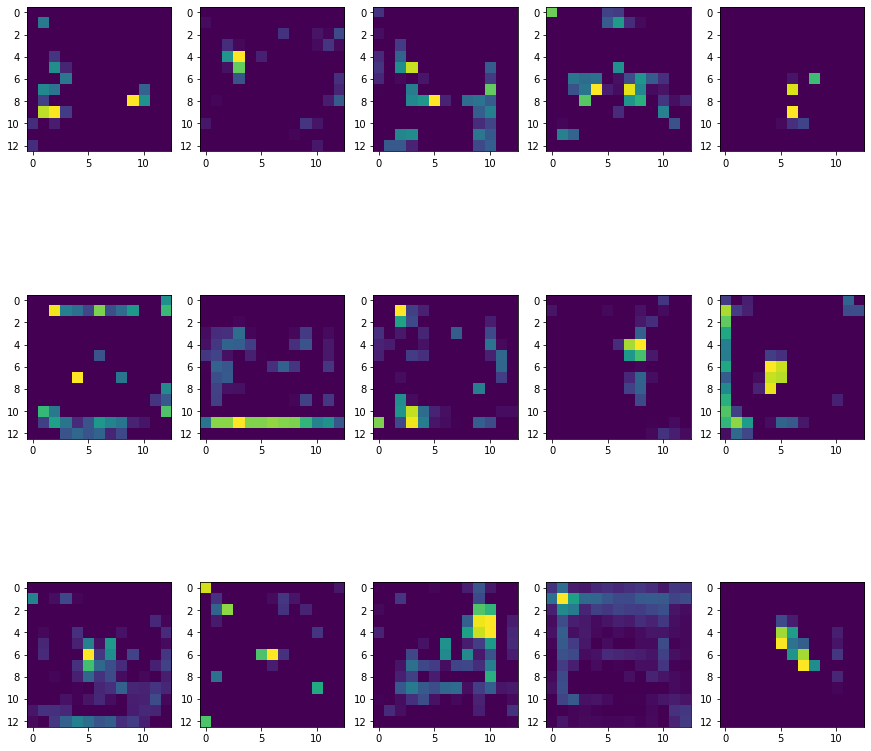

In [60]:
print("ブロック3の特徴量")
fig, axes = plt.subplots(3, 5, figsize=(15,15))
axes[0,0].imshow(model_features['conv_block_3'][0, block3_index].detach().cpu().numpy())
axes[0,1].imshow(model_features['conv_block_3'][0, block3_index + 1].detach().cpu().numpy())
axes[0,2].imshow(model_features['conv_block_3'][0, block3_index + 2].detach().cpu().numpy())
axes[0,3].imshow(model_features['conv_block_3'][0, block3_index + 3].detach().cpu().numpy())
axes[0,4].imshow(model_features['conv_block_3'][0, block3_index + 4].detach().cpu().numpy())
axes[1,0].imshow(model_features['conv_block_3'][0, block3_index + 5].detach().cpu().numpy())
axes[1,1].imshow(model_features['conv_block_3'][0, block3_index + 6].detach().cpu().numpy())
axes[1,2].imshow(model_features['conv_block_3'][0, block3_index + 7].detach().cpu().numpy())
axes[1,3].imshow(model_features['conv_block_3'][0, block3_index + 8].detach().cpu().numpy())
axes[1,4].imshow(model_features['conv_block_3'][0, block3_index + 9].detach().cpu().numpy())
axes[2,0].imshow(model_features['conv_block_3'][0, block3_index + 10].detach().cpu().numpy())
axes[2,1].imshow(model_features['conv_block_3'][0, block3_index + 11].detach().cpu().numpy())
axes[2,2].imshow(model_features['conv_block_3'][0, block3_index + 12].detach().cpu().numpy())
axes[2,3].imshow(model_features['conv_block_3'][0, block3_index + 13].detach().cpu().numpy())
axes[2,4].imshow(model_features['conv_block_3'][0, block3_index + 14].detach().cpu().numpy())
block3_index += 1

### Conv Block 4

In [24]:
block4_index = 0

ブロック4の特徴量


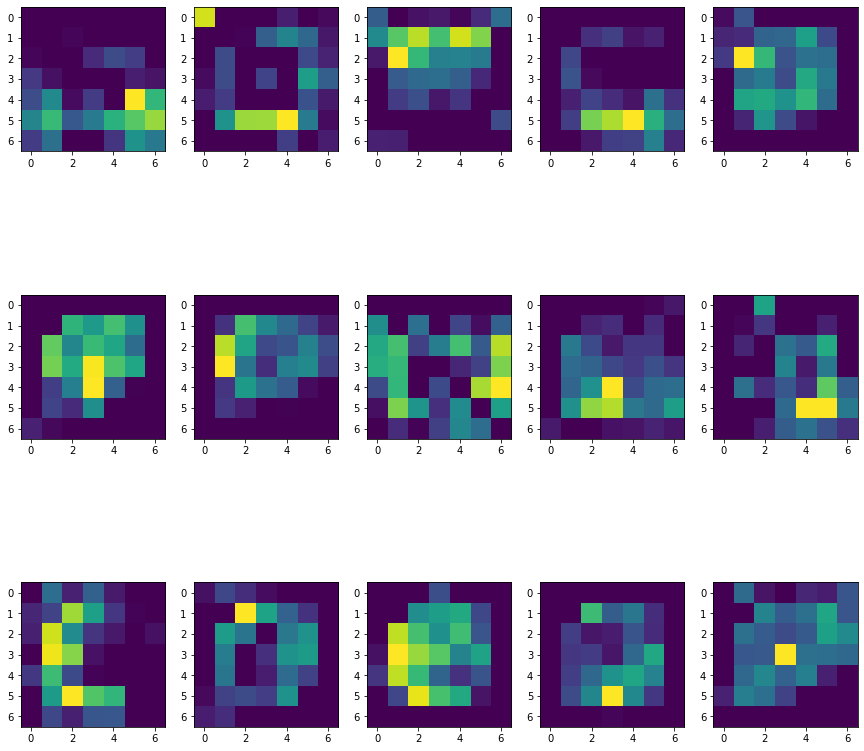

In [41]:
print("ブロック4の特徴量")
fig, axes = plt.subplots(3, 5, figsize=(15,15))
axes[0,0].imshow(model_features['conv_block_4'][0, block4_index].detach().cpu().numpy())
axes[0,1].imshow(model_features['conv_block_4'][0, block4_index + 1].detach().cpu().numpy())
axes[0,2].imshow(model_features['conv_block_4'][0, block4_index + 2].detach().cpu().numpy())
axes[0,3].imshow(model_features['conv_block_4'][0, block4_index + 3].detach().cpu().numpy())
axes[0,4].imshow(model_features['conv_block_4'][0, block4_index + 4].detach().cpu().numpy())
axes[1,0].imshow(model_features['conv_block_4'][0, block4_index + 5].detach().cpu().numpy())
axes[1,1].imshow(model_features['conv_block_4'][0, block4_index + 6].detach().cpu().numpy())
axes[1,2].imshow(model_features['conv_block_4'][0, block4_index + 7].detach().cpu().numpy())
axes[1,3].imshow(model_features['conv_block_4'][0, block4_index + 8].detach().cpu().numpy())
axes[1,4].imshow(model_features['conv_block_4'][0, block4_index + 9].detach().cpu().numpy())
axes[2,0].imshow(model_features['conv_block_4'][0, block4_index + 10].detach().cpu().numpy())
axes[2,1].imshow(model_features['conv_block_4'][0, block4_index + 11].detach().cpu().numpy())
axes[2,2].imshow(model_features['conv_block_4'][0, block4_index + 12].detach().cpu().numpy())
axes[2,3].imshow(model_features['conv_block_4'][0, block4_index + 13].detach().cpu().numpy())
axes[2,4].imshow(model_features['conv_block_4'][0, block4_index + 14].detach().cpu().numpy())
block4_index += 1

In [42]:
model

ResNet50(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kerne